In [1]:
import re
import time
from datetime import datetime

import requests
from bs4 import BeautifulSoup
from selenium import webdriver

from IPython.display import Image
import pandas as pd
import numpy as np


from pykrx import stock
import FinanceDataReader as fdr
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import FinanceDataReader as fdr
import finterstellar as fs


import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('max_colwidth', None)
plt.rcParams['font.family']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


['Malgun Gothic']

In [2]:
excel = pd.read_excel("./datasets/실습07_펀드_운용모델.xlsx", sheet_name='펀드', index_col=0, header=[0,1])
excel.columns = [x if y[0]=='U' else y for x, y in excel.columns]
excel

,A전자,B건설,C증권,D화학,E엔터,지수,설정좌수(CU:5만),환매좌수,총좌수,iNAV(지수변동률*기준가),...,A전자,B건설,C증권,D화학,E엔터,A전자,B건설,C증권,D화학,E엔터
2020-01-02,0.060241,0.072289,0.395181,0.070683,0.401606,100.000000,1000000.0,0.0,1000000.0,10000.000000,...,60240.963855,36144.578313,131726.907631,7068.273092,4016.064257,60240.963855,36144.578313,131726.907631,7068.273092,4016.064257
2020-01-03,0.062181,0.074614,0.398604,0.069730,0.394871,99.389116,150000.0,0.0,1150000.0,9938.911647,...,9036.144578,5421.686747,19759.036145,1060.240964,602.409639,69277.108434,41566.265060,151485.943775,8128.514056,4618.473896
2020-01-04,0.061164,0.073988,0.395840,0.069988,0.399020,99.121266,150000.0,0.0,1300000.0,9912.126586,...,9036.144578,5421.686747,19759.036145,1060.240964,602.409639,78313.253012,46987.951807,171244.979920,9188.755020,5220.883534
2020-01-05,0.063402,0.076215,0.390162,0.070046,0.400176,98.007960,200000.0,100000.0,1400000.0,9800.795984,...,6024.096386,3614.457831,13172.690763,706.827309,401.606426,84337.349398,50602.409639,184417.670683,9895.582329,5622.489960
2020-01-06,0.062458,0.073575,0.383911,0.070898,0.409158,98.650063,100000.0,50000.0,1450000.0,9865.006265,...,3012.048193,1807.228916,6586.345382,353.413655,200.803213,87349.397590,52409.638554,191004.016064,10248.995984,5823.293173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 종목기본정보

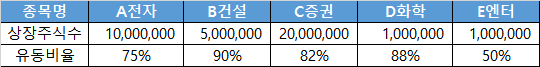!

## 관심종목

In [3]:
티커리스트 = stock.get_market_cap('2022-12-01').sort_values('시가총액', ascending=False)[:7].index
티커리스트

Index(['005930', '373220', '207940', '000660', '051910', '006400', '005935'], dtype='object', name='티커')

In [4]:
종목리스트 = []

for 티커 in 티커리스트:
    종목 = stock.get_market_ticker_name(티커)
    종목리스트.append(종목)
    
종목리스트

['삼성전자', 'LG에너지솔루션', '삼성바이오로직스', 'SK하이닉스', 'LG화학', '삼성SDI', '삼성전자우']

In [5]:
관심종목 = pd.DataFrame(종목리스트, index=티커리스트, columns=['종목명'])
관심종목 = 관심종목.drop(['373220', '005935'])
관심종목

,종목명
티커,
005930,삼성전자
207940,삼성바이오로직스
000660,SK하이닉스
051910,LG화학
006400,삼성SDI


In [6]:
관심종목.to_dict()['종목명']

{'005930': '삼성전자',
 '207940': '삼성바이오로직스',
 '000660': 'SK하이닉스',
 '051910': 'LG화학',
 '006400': '삼성SDI'}

## 유동비율

In [7]:
종목기본정보 = pd.DataFrame(index=['상장주식수', '유동비율'], columns=관심종목.index.values)

for 티커 in 관심종목.index:
    url = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd='
    url = url + 티커
    res = requests.get(url)
    if res.status_code == 200:
        soup = BeautifulSoup(res.text, 'html.parser')
        발행주식수_유동비율 = soup.select_one('#cTB11 > tbody > tr:nth-child(7) > td').text.strip()

    발행주식수, 유동비율 = 발행주식수_유동비율.split('/')
    발행주식수 = int(발행주식수.strip()[:-1].replace(',', ''))
    유동비율 = float(유동비율.strip()[:-1])
    
    종목기본정보.at['상장주식수', 티커] = 발행주식수
    종목기본정보.at['유동비율', 티커] = 유동비율

종목기본정보 = 종목기본정보.rename(columns=관심종목.to_dict()['종목명'])
종목기본정보

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
상장주식수,5969782550,71174000,728002365,70592343,68764530
유동비율,75.81,24.76,73.87,66.63,73.16


# 일자별주가

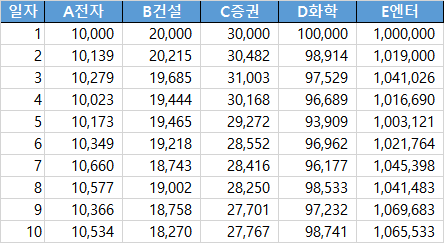!

In [8]:
일자별주가 = pd.DataFrame()

for 티커 in 관심종목.index:
    종가 = stock.get_market_ohlcv('20200101', '20221231', 티커)['종가']
    종가.name = 관심종목.at[티커, '종목명']
    일자별주가 = pd.concat([일자별주가, 종가], axis=1)
    
일자별주가

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
2020-01-02,55200,423485,94700,314000,232000
2020-01-03,55500,417061,94500,311000,229000
2020-01-06,55500,407178,94300,307000,230000
2020-01-07,55800,414096,94000,311000,231500
2020-01-08,56800,403719,97400,302000,229000
...,...,...,...,...,...
2022-12-23,58100,806000,77800,610000,622000
2022-12-26,57900,822000,77000,618000,624000
2022-12-27,58100,828000,77000,628000,624000
2022-12-28,56600,830000,76000,602000,603000


# 일별시가총액

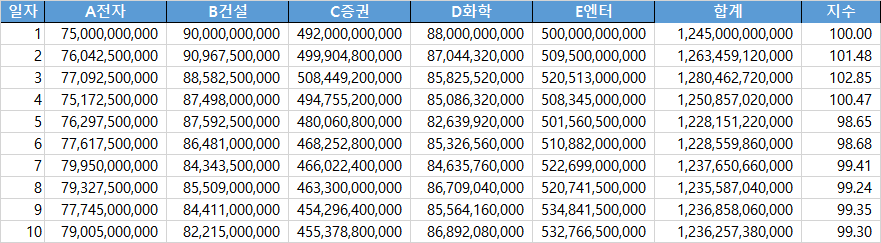!

In [9]:
유동주식수 = 종목기본정보.loc['상장주식수']*종목기본정보.loc['유동비율']*0.01
유동주식수

삼성전자        4525692151.155
삼성바이오로직스        17622682.4
SK하이닉스      537775347.0255
LG화학         47035678.1409
삼성SDI         50308130.148
dtype: object

In [10]:
일별시가총액 = pd.DataFrame()

for 종목명 in 관심종목['종목명'].values:
    temp = 일자별주가[종목명]*유동주식수[종목명]
    일별시가총액 = pd.concat([일별시가총액, temp], axis=1)
    
일별시가총액['합계'] = 일별시가총액.sum(axis=1)
기준 = 일별시가총액.loc[일별시가총액.index[0],'합계']
일별시가총액['지수'] = 일별시가총액['합계']/기준*100
일별시가총액

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,합계,지수
2020-01-02,2.498182e+14,7.462942e+12,5.092733e+13,1.476920e+13,1.167149e+13,3.346492e+14,100.000000
2020-01-03,2.511759e+14,7.349734e+12,5.081977e+13,1.462810e+13,1.152056e+13,3.354941e+14,100.252477
2020-01-06,2.511759e+14,7.175569e+12,5.071222e+13,1.443995e+13,1.157087e+13,3.350745e+14,100.127106
2020-01-07,2.525336e+14,7.297482e+12,5.055088e+13,1.462810e+13,1.164633e+13,3.366564e+14,100.599808
2020-01-08,2.570593e+14,7.114612e+12,5.237932e+13,1.420477e+13,1.152056e+13,3.422786e+14,102.279826
...,...,...,...,...,...,...,...
2022-12-23,2.629427e+14,1.420388e+13,4.183892e+13,2.869176e+13,3.129166e+13,3.789689e+14,113.243654
2022-12-26,2.620376e+14,1.448584e+13,4.140870e+13,2.906805e+13,3.139227e+13,3.783924e+14,113.071385
2022-12-27,2.629427e+14,1.459158e+13,4.140870e+13,2.953841e+13,3.139227e+13,3.798737e+14,113.514007
2022-12-28,2.561542e+14,1.462683e+13,4.087093e+13,2.831548e+13,3.033580e+13,3.703032e+14,110.654157


# 펀드

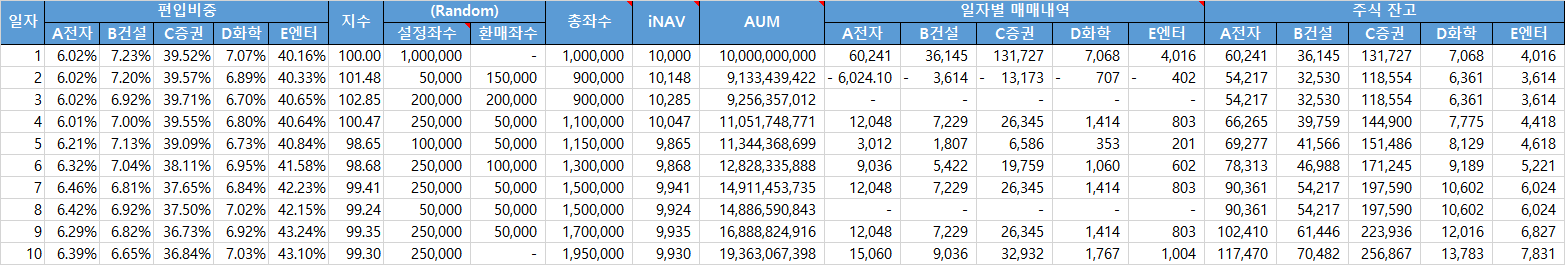!

## 편입비중

In [11]:
편입비중 = pd.DataFrame()

for 날짜 in 일별시가총액.index:
    temp = 일별시가총액.loc[날짜, 관심종목['종목명'].values] / 일별시가총액.at[날짜, '합계']
    편입비중 = pd.concat([편입비중, temp], axis=1)
    
편입비중 = pd.concat([편입비중.T, 일별시가총액['지수']], axis=1)
편입비중

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,지수
2020-01-02,0.746508,0.022301,0.152181,0.044133,0.034877,100.000000
2020-01-03,0.748675,0.021907,0.151477,0.043602,0.034339,100.252477
2020-01-06,0.749612,0.021415,0.151346,0.043095,0.034532,100.127106
2020-01-07,0.750123,0.021676,0.150156,0.043451,0.034594,100.599808
2020-01-08,0.751024,0.020786,0.153031,0.041501,0.033658,102.279826
...,...,...,...,...,...,...
2022-12-23,0.693837,0.037480,0.110402,0.075710,0.082571,113.243654
2022-12-26,0.692502,0.038283,0.109433,0.076820,0.082962,113.071385
2022-12-27,0.692185,0.038412,0.109007,0.077758,0.082639,113.514007
2022-12-28,0.691742,0.039500,0.110372,0.076466,0.081922,110.654157


In [12]:
좌수 = pd.read_csv('./datasets/실습07_설정환매_랜덤.csv', parse_dates=[0], index_col=0)
좌수['총좌수'] = 좌수.sum(axis=1)
좌수['iNAV'] = 10000*편입비중['지수']/편입비중['지수']
좌수

,설정,환매,총좌수,iNAV
날짜,,,,
2020-01-02,1000000,0,1000000,10000.0
2020-01-03,50000,0,50000,10000.0
2020-01-06,150000,100000,250000,10000.0
2020-01-07,100000,100000,200000,10000.0
2020-01-08,150000,100000,250000,10000.0
...,...,...,...,...
2022-12-23,50000,0,50000,10000.0
2022-12-26,150000,100000,250000,10000.0
2022-12-27,200000,100000,300000,10000.0


In [15]:
df2 = pd.read_csv("./datasets/실습07_설정환매_랜덤.csv")
df2

,날짜,설정,환매
0,2020-01-02,1000000,0
1,2020-01-03,50000,0
2,2020-01-06,150000,100000
3,2020-01-07,100000,100000
4,2020-01-08,150000,100000
...,...,...,...
737,2022-12-23,50000,0
738,2022-12-26,150000,100000
739,2022-12-27,200000,100000
740,2022-12-28,100000,50000


In [16]:
df2.shape

(742, 3)

* 일자별 매매내역 = (AUM * 5개 종목 편입비율) * 100 / 5개 종목 각 일자별 주가


In [18]:
excel.columns

Index(['A전자', 'B건설', 'C증권', 'D화학', 'E엔터', '지수', '설정좌수(CU:5만)', '환매좌수', '총좌수',
       'iNAV(지수변동률*기준가)', 'AUM', 'A전자', 'B건설', 'C증권', 'D화학', 'E엔터', 'A전자',
       'B건설', 'C증권', 'D화학', 'E엔터'],
      dtype='object')

In [36]:
일자별매매내역 = pd.DataFrame(columns=관심종목.index.values)

result = []

for x in range(len(excel['AUM'])):
    for y in 편입비중.columns:
        product = excel['AUM'][i] * (편입비중[j]*100)
        for z in range(len(일자별주가)):
            quotient = product / 일자별주가[z]
    result.append(quotient)

print(result)

KeyError: 0

* 주식잔고 = 5개 종목 각 주식잔고.iloc[0] + 그날 잔고 

In [ ]:
주식잔고 = pd.DataFrame()
일자별매매내역.iloc[:,]
주식잔고